# Topic Classification with a Feedforward Network

The goal of this project is to develop a Feedforward neural network for topic classification. 

For that purpose, we will implement:

- Text processing methods for transforming raw text data into input vectors for the network  

- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix** 
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** 
    - **Output layer** with a **softmax** activation. 

- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of the Neural network. The algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function 
    - Perform a **Forward pass** to compute intermediate outputs 
    - Perform a **Backward pass** to compute gradients and update all sets of weights 
    - Implement and use **Dropout** after each hidden layer for regularisation


- Discuss how hyperparameters were chosen and use tables or graphs to show training and validation performance for each hyperparameter combination. 


- After training a model, we plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy. Does the model overfit, underfit or is about right?



- Re-train the network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, we initialise it with the pre-trained weights. During training, freeze the weights and report results by performing hyperparameter tuning and plotting the learning process. Do we get better performance?



- Extend the Feedforward network by adding more hidden layers and observe how it affects the performance.


### Data 

The data we will use for the task is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and we can find it in the `./data` folder in CSV format:

- `data/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

Class 1: Politics, Class 2: Sports, Class 3: Economy


In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
import zipfile
import gc

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files using Pandas dataframes.

In [2]:
def read_data(file):
    df = pd.read_csv(file) #read csv file into pandas dataframe
    df.set_axis(['class_id','text'],axis=1,inplace=True) #add index to dataframe rows
    return df

df_train = read_data('data/train.csv')
df_dev = read_data('data/dev.csv')
df_test = read_data('data/test.csv')

df_train

,class_id,text
0,1,Reuters - South Korean police used water canno...
1,1,Reuters - Thousands of Palestinian\prisoners i...
2,1,AFP - Sporadic gunfire and shelling took place...
3,1,AP - Dozens of Rwandan soldiers flew into Suda...
4,1,Reuters - Rwandan troops were airlifted on Sun...
...,...,...
2394,3,"Australia #39;s dominant airline, Qantas, has ..."
2395,3,Reuters - Medtronic Inc. (MDT.N) on Wednesday\...
2396,3,SAN FRANCISCO (Reuters) - Google Inc. &lt;A H...
2397,3,"BHP Billiton, the world #39;s biggest mining c..."


# Create input representations


To train the Feedforward network, we first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices.


## Text Pre-Processing Pipeline
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [3]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']


### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [4]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
                   stop_words=[], vocab=set()):
    
    ngrams=[]
    #normalise sentences to lowercase and extract words with pattern of interest
    words = re.findall(token_pattern,x_raw.lower())
    for n in range(ngram_range[0],ngram_range[1]+1):
        for i in range(len(words)-n+1):
            ngram=words[i:i+n] #get words within given window
            if not set(ngram).intersection(set(stop_words)):
                ngrams.append(' '.join(ngram)) #add words as a feature if not a stopword
    if vocab:
        ngrams=list(set(ngrams).intersection(vocab)) #remove non-vocabulary words
    return ngrams

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [5]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
              min_df=0, keep_topN=0, 
              stop_words=[]):
    
    ngram_counts=dict()
    vocab=set()
    df=dict()
    doc_count=0
    
    for index, row in X_raw.iterrows(): 
        doc_count+=1 #increment document count for each new sentences
        
        #get all ngrams from each sentence/document
        ngrams = extract_ngrams(x_raw=row["text"],stop_words=stop_words,\
                                ngram_range=ngram_range,token_pattern=token_pattern)
        
        tokens_in_doc=set()
        for token in ngrams:
            vocab.add(token) #add ngrams to vocabulary; vocab is a set to avoid duplicates
            if token in ngram_counts: #update ngram counter
                ngram_counts[token]=ngram_counts[token]+1 
            else:
                ngram_counts[token]=1
            
            #update document frequency for tokens
            if not token in tokens_in_doc: 
                if token in df:
                    df[token]=df[token]+1 #update count for existing tokens in a document
                else:
                    df[token]=1 #update count for new tokens in a document
                tokens_in_doc.add(token)
    
    if min_df>0: #keep only ngrams with at least a certain document frequency
        ngram_counts=dict([(key, value) for key,value in ngram_counts.iteritems() if df[key]>=min_df])
        
    if keep_topN>0: #remove ngrams with less than a certain frequency in the vocabulary
        ngram_counts=dict(sorted(ngram_counts.items(), key=lambda item: item[1], reverse=True))
        import itertools
        ngram_counts = dict(itertools.islice(ngram_counts.items(), keep_topN))
        vocab = vocab.intersection(ngram_counts.keys())
    
    return vocab, df, ngram_counts


Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [6]:
vocab,doc_freq,raw_frew=get_vocab(df_train,keep_topN=10000,stop_words=stop_words)

Then, you need to create vocabulary id -> word and word -> vocabulary id dictionaries for reference:

In [7]:
word_to_vocab_id={x:list(vocab).index(x)  for x in vocab}
vocab_id_to_word={list(vocab).index(x):x  for x in vocab}

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [8]:
#extract all vocabulary ngrams from data sets and store as list for each document
def convert_to_vocab_list(df):
    df = df['text']
    df = df.apply(lambda x: extract_ngrams(x,stop_words=stop_words,vocab=vocab))
    return df

train_vocab_df=convert_to_vocab_list(df_train)
dev_vocab_df=convert_to_vocab_list(df_dev)
test_vocab_df=convert_to_vocab_list(df_test)


Then convert them into lists of indices in the vocabulary:

In [9]:
#convert all vocabulary ngrams to vocabulary indices for each document
def vocab_list_to_index(df):
    df = df.apply(lambda vocab_list: np.array([word_to_vocab_id[word] for word in vocab_list]))
    return list(df.to_numpy())

X_tr=vocab_list_to_index(train_vocab_df)
X_dev=vocab_list_to_index(dev_vocab_df)
X_test=vocab_list_to_index(test_vocab_df)


Put the labels `Y` for train, dev and test sets into arrays: 

In [10]:
#convert data labels into one-hot encodings per class to calculate categorical loss
def encode_labels(df):
    classes=df['class_id'].to_numpy() - 1 #subtract one from class to get active index 
    encodings=np.zeros((len(df),3), dtype=int)
    encodings[np.arange(len(df)),classes]=1
    return list(encodings)

Y_tr=encode_labels(df_train)
Y_dev=encode_labels(df_dev)

#test labels are not one-hot encoded for predictions later
Y_test=list(df_test['class_id'])

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers. Empty if there are no hidden layers between the average embedding and the output layer 
- `num_classes`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [11]:
def network_weights(vocab_size=1000, embedding_dim=300, 
                    hidden_dim=[], num_classes=3, init_val = 0.5):
    
    #initialize weights dict
    W=dict()
    
    #append input and output layer dimensions with hidden layer dimensions
    hidden_dim.insert(0,embedding_dim)
    hidden_dim.insert(0,vocab_size)
    hidden_dim.append(num_classes)
    
    for n in range(len(hidden_dim)-1):
        #initialize weights w.r.t. the number of nodes in adjacent layers
        W[n]=np.random.uniform(-0.1,0.1,(hidden_dim[n],hidden_dim[n+1])) 

    return W
    

In [12]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[2], num_classes=2)

for i,j in W.items():
    print(i,":", j.shape)

0 : (3, 4)
1 : (4, 2)
2 : (2, 2)


Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. 

It takes as input `z` (array of real numbers) and returns `sig` (the softmax of `z`)



In [13]:
#compute softmax per layer 

def softmax(z):
    z_exp = np.exp(z)
    sig = z_exp/np.sum(z_exp)
    return sig


Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:


In [14]:
#compute cross entropy loss for output layers

def categorical_loss(y, y_preds):
    l = -np.dot(y,np.log(y_preds + 1e-20)) #1e-20 is a scaling factor against taking the log of 0 values
    return l

Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network 
(during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

  
  relu_derivative($z_i$)=0, if $z_i$<=0, 1 otherwise.
  


Note that both functions take as input a vector $z$ 

We use .copy() to avoid in place changes in array z

In [15]:
#compute relu for each layer-wise
def relu(z):
    a = np.fmax(z,np.zeros_like(z))
    return a

#compute the derivate layer-wise
def relu_derivative(z):
    z_copy = z.copy()
    rd=relu(z_copy)
    dz=np.where(rd<=0.,0,1)
    return dz

During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [16]:
#compute dropout mask layer-wise
def dropout_mask(size, dropout_rate):
    zero_idx = set()
    dropout_vec = np.ones((size,))

    while len(zero_idx) < dropout_rate*size:
        idx = random.randint(0, size-1)
        if idx not in zero_idx:
            zero_idx.add(idx)
            dropout_vec[idx] = 0
    return dropout_vec
    

In [17]:
print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [18]:
def forward_pass(x, W, dropout_rate=0.2):
    
    out_vals = {}
    
    h_vecs = []
    a_vecs = []
    dropout_vecs = []

    for layer,weights in W.items():
        if layer==0: #compute embedding layer by summing active indices in the input vector
            h=np.zeros(W[0].shape[1])
            for idx in x:
                h+=W[0][idx]
        else:
            a=a*d #apply dropout mask to the activation from the previous layer
            h=weights.T@a #multiply previous layer nodes with weights for the next layer to compute the next layer
        
        a=relu(h) #apply relu activation to a layer
        d=dropout_mask(a.shape,dropout_rate) #generate dropout mask for a layer
        
        a_vecs.append(a)
        dropout_vecs.append(d)
        h_vecs.append(h)
    
    y=softmax(a) #apply softmax to final (output) layer
    #update dictionary
    out_vals['h']=h_vecs
    out_vals['a']=a_vecs
    out_vals['d']=dropout_vecs
    out_vals['y']=y 
    
    return out_vals

The `backward_pass` function computes the gradients and updates the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [19]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False):

    W_rev = dict(reversed(list(W.items()))) #reverse the weight dictionary
    
    grad={} #dictionary of gradients, emptied each time backward pass is performed
    g=out_vals['y']-y #derivative of the loss function w.r.t. the final/output layer with the softmax function
    for layer,weights in W_rev.items():
        if layer-1>=0: #for intermediate layers
            
            #derivate of a layer before activation function applying chain rule
            g=g.flatten()*relu_derivative(out_vals['h'][layer]) 
            
            #derivate of the loss function w.r.t. layer weights applying chain rule
            grad[layer]=out_vals['a'][layer-1].reshape(-1,1)@g.reshape(1,-1) 
            
            #derivative of the loss function w.r.t. hidden layers
            g=g.reshape(1,-1)@weights.T 
        
        else:
            if not freeze_emb:
                #compute embedding layer gradients
                w = np.zeros((W[0].shape))
                for idx in x:
                    w[idx]=g.reshape(1,-1)
                grad[0]=w
            else: #keep embedding layer gradients as 0 so as not to update
                grad[0]=np.zeros_like(W[0])

    for layer,weights in W.items(): #subtract computed gradients from current weights w.r.t. to learning rate
        W[layer] = W[layer]-lr*grad[layer]
        
    return W


Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [20]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, 
        print_progress=True):
    
    training_loss_history=[]
    validation_loss_history=[]
    
    random.seed(123)
    
    for e in range(epochs): #iterate through all data instances for each epoch
        
        running_loss_tr=0 #initialize training loss for each epoch
        
        #shuffle train data
        tr_shuf = list(zip(X_tr,Y_tr))
        random.shuffle(tr_shuf)
        X_tr,Y_tr=zip(*tr_shuf)
        
        #train model
        for i in range(len(X_tr)):
            #perform forward pass
            out_vals=forward_pass(X_tr[i], W, dropout_rate=dropout)
            #perform backward pass and adjust gradients 
            W = backward_pass(X_tr[i], Y_tr[i], W, out_vals=out_vals, lr=lr, freeze_emb=freeze_emb)
            #compute cross entropy loss for output layer and sum up
            running_loss_tr+=categorical_loss(Y_tr[i], out_vals['y'])
        #calculate average cross entropy loss for each epoch
        loss=(running_loss_tr/len(X_tr))
        print("Epoch: %i \t Train Loss: %.5f"%(e+1, loss))
        training_loss_history.append(loss)
        
        running_loss_dev=0 #initialize validation loss for each epoch
        
        #shuffle valid data
        dev_shuf = list(zip(X_dev,Y_dev))
        random.shuffle(dev_shuf)
        X_dev,Y_dev=zip(*dev_shuf)
        
        #validate model by making predctions on validation set
        for i in range(len(X_dev)):
            out_vals=forward_pass(X_dev[i], W, dropout_rate=dropout)
            running_loss_dev+=categorical_loss(Y_dev[i], out_vals['y'])
        #calculate average cross entropy loss for each epoch
        loss=(running_loss_dev/len(X_dev))
        print("Epoch: %i \t Validation Loss: %.5f"%(e+1, loss))
        validation_loss_history.append(loss)
        
        val_loss_diff=1 #initalize validation loss difference with a large value
        if len(validation_loss_history)>1:
            #calculate validation loss difference by subtracting
            val_loss_diff=abs(validation_loss_history[-2]-validation_loss_history[-1])
        
        #stop training if validation loss difference is below the threshold
        if val_loss_diff<tolerance:
            break
        
    return W, training_loss_history, validation_loss_history


Now you are ready to train and evaluate your neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [21]:
#initialize network weights
W = network_weights(vocab_size=len(vocab),embedding_dim=120,
                    hidden_dim=[], num_classes=3)

#layer dimensions
for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)


epochs = 5

W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=0.01, 
                            dropout=0.1,
                            freeze_emb=False,
                            tolerance=1e-6,
                            epochs=epochs)


Shape W0 (46969, 120)
Shape W1 (120, 3)
Epoch: 1 	 Train Loss: 0.80102
Epoch: 1 	 Validation Loss: 0.59110
Epoch: 2 	 Train Loss: 0.29265
Epoch: 2 	 Validation Loss: 0.42161
Epoch: 3 	 Train Loss: 0.11504
Epoch: 3 	 Validation Loss: 0.35435
Epoch: 4 	 Train Loss: 0.06087
Epoch: 4 	 Validation Loss: 0.35107
Epoch: 5 	 Train Loss: 0.04041
Epoch: 5 	 Validation Loss: 0.33347


Plot the learning process:

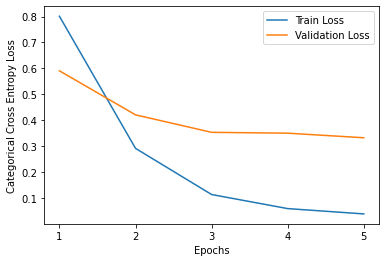

In [22]:
def plot_loss(loss_tr,dev_loss):
    x_ax = [i for i in range(1, len(loss_tr)+1)]
    
    plt.plot(x_ax,loss_tr,label='Train Loss')
    plt.plot(x_ax,dev_loss,label='Validation Loss')
    plt.legend()
    plt.xticks(x_ax)
    plt.xlabel("Epochs")
    plt.ylabel("Categorical Cross Entropy Loss")
    plt.show()
    
    return

#plot
plot_loss(loss_tr,dev_loss)

Compute accuracy, precision, recall and F1-Score:

In [23]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])+1 
            for x,y in zip(X_test,Y_test)]

print('Accuracy:', accuracy_score(Y_test,preds_te))
print('Precision:', precision_score(Y_test,preds_te,average='macro'))
print('Recall:', recall_score(Y_test,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_test,preds_te,average='macro'))

Accuracy: 0.8542825361512792
Precision: 0.8551011528512942
Recall: 0.854247491638796
F1-Score: 0.8538293762746418


In [24]:
#count number of misclassifications per class
def count_errors(preds_te):
    c1=0
    c2=0
    c3=0
    for i in range(len(Y_test)):
        if preds_te[i] == Y_test[i]:
            continue
        else:
            if Y_test[i] == 1:
                c1+=1
            elif Y_test[i] == 2:
                c2+=1
            elif Y_test[i] == 3:
                c3+=1
    print("Errors per class:", c1,c2,c3) 
    
count_errors(preds_te)

Errors per class: 53 22 56


### Discuss how did you choose model hyperparameters ? 

ANSWER: Model hyperparameters were tuned via trial and error. Higher embedding dimension sizes and more epochs result in lower training and validation loss. However, due to time constraints on the running time for the notebook, smaller values were selected. Further, a very small learning rate slows down the model from convergence. From the plotting of the train and validation loss, and the few number of training epochs, the model neither overfits nor underfits.


**Note**: All models were trained for 5 epochs


| Learning Rate | Embedding Size | Dropout Rate | Accuracy |
| --- | --- | --- | --- |
| 0.0001 | 80 | 0.4 | 0.37263
| 0.001 | 90 | 0.2 | 0.62958
| 0.01 | 120 | 0.1 | 0.85428

# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings.

In [25]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    
    w_emb = np.zeros((len(word2id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in vocab:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]] +=emb
    return w_emb

In [26]:
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",word_to_vocab_id)

In [27]:
w_glove.shape

(46969, 300)

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [28]:
W=network_weights(vocab_size=len(vocab),embedding_dim=300,
                    hidden_dim=[], num_classes=3)
W[0]=w_glove

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)
    
W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=0.001, 
                            dropout=0.1,
                            freeze_emb=True,
                            tolerance=1e-6,
                            epochs=epochs)

Shape W0 (46969, 300)
Shape W1 (300, 3)
Epoch: 1 	 Train Loss: 1.10030
Epoch: 1 	 Validation Loss: 1.09861
Epoch: 2 	 Train Loss: 1.05851
Epoch: 2 	 Validation Loss: 0.84340
Epoch: 3 	 Train Loss: 0.91279
Epoch: 3 	 Validation Loss: 0.78137
Epoch: 4 	 Train Loss: 0.87740
Epoch: 4 	 Validation Loss: 0.79018
Epoch: 5 	 Train Loss: 0.84549
Epoch: 5 	 Validation Loss: 0.72931


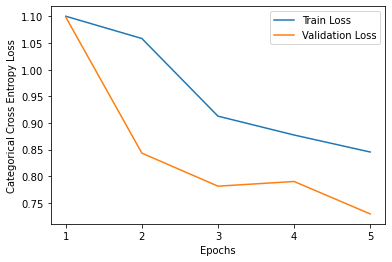

In [29]:
#plot
plot_loss(loss_tr,dev_loss)

In [30]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])+1 
            for x,y in zip(X_test,Y_test)]

print('Accuracy:', accuracy_score(Y_test,preds_te))
print('Precision:', precision_score(Y_test,preds_te,average='macro'))
print('Recall:', recall_score(Y_test,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_test,preds_te,average='macro'))

Accuracy: 0.8020022246941045
Precision: 0.8210869288508459
Recall: 0.8020810107766629
F1-Score: 0.8040548886422948


In [31]:
#error analysis
count_errors(preds_te)

Errors per class: 38 51 89


### Discuss how did you choose model hyperparameters ? 

ANSWER: Model hyperparameters were chosen via trial and error. A large learning rate of 0.1 to 0.01 does not allow the the model to converge. Similarly, dropout mask size was reduced to avoid underfitting. From the plotting of the train and validation loss, and the few number of epochs, the model may underfit.

**Note**: All models were trained for 5 epochs


| Learning Rate | Dropout Rate | Accuracy |
| --- | --- | --- |
| 0.0001 | 0.1 | 0.62068
| 0.0001 | 0.2 | 0.41379
| 0.001 | 0.1 | 0.80200

# Extend to support deeper architectures 

Extend the network to support back-propagation for more hidden layers. We modify the `backward_pass` function to compute gradients and update the weights between intermediate hidden layers. We also train and evaluate a network with a deeper architecture to test if deeper architectures increase performance.

In [32]:
W=network_weights(vocab_size=len(vocab),embedding_dim=300,
                    hidden_dim=[50], num_classes=3)
W[0]=w_glove

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=0.0001, 
                            dropout=0.1,
                            freeze_emb=True,
                            tolerance=1e-6,
                            epochs=epochs)

Shape W0 (46969, 300)
Shape W1 (300, 50)
Shape W2 (50, 3)
Epoch: 1 	 Train Loss: 0.95492
Epoch: 1 	 Validation Loss: 0.90049
Epoch: 2 	 Train Loss: 0.81113
Epoch: 2 	 Validation Loss: 0.82343
Epoch: 3 	 Train Loss: 0.75336
Epoch: 3 	 Validation Loss: 0.77906
Epoch: 4 	 Train Loss: 0.72153
Epoch: 4 	 Validation Loss: 0.74675
Epoch: 5 	 Train Loss: 0.69175
Epoch: 5 	 Validation Loss: 0.65494


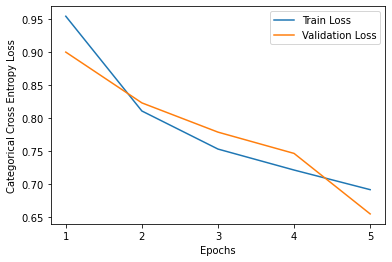

In [33]:
#plot
plot_loss(loss_tr,dev_loss)

In [34]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])+1 
            for x,y in zip(X_test,Y_test)]

print('Accuracy:', accuracy_score(Y_test,preds_te))
print('Precision:', precision_score(Y_test,preds_te,average='macro'))
print('Recall:', recall_score(Y_test,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_test,preds_te,average='macro'))

Accuracy: 0.8264738598442715
Precision: 0.8311809551886201
Recall: 0.8265068747677443
F1-Score: 0.8272040144554834


In [35]:
#error analysis
count_errors(preds_te)

Errors per class: 43 53 60


### Discuss how did you choose model hyperparameters ? 

ANSWER: Model hyperparameters were chosen via trial and error. Increasing the number of nodes in the hidden layers may or may not increase the accuracy. The same goes for the depth of the network. Other hyperparameters were regulated the same way as previous steps. From the plotting of the train and validation loss, and the few number of epochs, the model may underfit.

**Note**: All models were trained for 5 epochs

| Learning Rate | Dropout Rate | Hidden Dimension Sizes | Accuracy
| --- | --- | --- | --- |
| 0.0001 | 0.1 | 90 | 0.74749
| 0.0001 | 0.2 | 120, 20 | 0.51946
| 0.0001 | 0.1 | 50 | 0.82647


## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  | 0.86589  | 0.86643  | 0.86563  | 0.85428  | 
| Average Embedding (Pre-trained)  | 0.82108  | 0.80208  | 0.80405  |  0.80200 |
| Average Embedding (Pre-trained) + X hidden layers    | 0.83118  | 0.82650  |  0.82720  |  0.82647 |


Why is the best performing model better than the rest? Provide a brief error analaysis.

**Results Analysis**

***Best Performing Model:***
From the results obtained above, it can be observed that the optimal value of the hyperparameters vary between model architectures. The best performing model with an accuracy and precision of over 85% does not use pre-trained, frozen embeddings. The reason why its performance is better than the other models may be atributed to the fact that it can adjust its embedding weights accordingly. Additionally, because very few epochs were run, model performance could improve if the model is trained for a longer time. It is important to note that due to contraints on the execution time of the notebook, very large values were not considered while carrying out experiments e.g. for the number of epochs, number of hidden layers and number of nodes per hidden layer.

***Error Analysis:***
The models appear to misclassify Class 3 and correctly classify Class 1 the most, despite the balance in training and validation data. Misclassifications can be explained by overlapping vocabulary between different classes. For example, a sentence containing the ngrams 'economy',  'sales', and 'billion' was misclassified as *Class 3 - Economy* instead of *Class 1 - Politics*. And sentences containing words like 'olympic', 'tournament', 'basketball' and 'quarterfinal' were incorrectly predicted as *Class 2 - Sports* as opposed to *Class 1 - Politics*. In such cases, it is clear where errors arise from. 